In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/task3_training.tsv', sep = '\t', engine='python')
df_test = pd.read_csv('/content/gdrive/My Drive/task3_validation.tsv', sep = '\t', engine='python')

In [0]:
#taking necessary columns
from io import StringIO
cols = ['extraction', 'meddra_term', 'meddra_code']
df_train = df_train[cols]
df_train = df_train[pd.notnull(df_train['meddra_term'])]

cols = ['extraction', 'meddra_term', 'meddra_code']
df_test = df_test[cols]
df_test = df_test[pd.notnull(df_test['meddra_term'])]

In [4]:
df_train.index

Int64Index([  27,   28,   29,   30,   31,   32,   33,   34,   36,   37,
            ...
            2218, 2221, 2223, 2228, 2234, 2239, 2240, 2242, 2244, 2245],
           dtype='int64', length=1464)

In [5]:
df_test.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   9,  10,  13,
            ...
            385, 386, 387, 388, 389, 390, 391, 392, 393, 394],
           dtype='int64', length=365)

In [0]:
#concatenating train and validation sets
df = pd.concat([df_train, df_test], ignore_index=True)

In [0]:
#converting from rangeIndex to Int64 Index
df.index = list(df.index)

In [8]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828],
           dtype='int64', length=1829)

In [0]:
#giving numbers to meddra_terms by adding column category_id
df['category_id'] = df['meddra_term'].factorize()[0]

In [10]:
df.tail()

,extraction,meddra_term,meddra_code,category_id
1824,hypochondria,hypochondriasis,10020965.0,476
1825,withdrawal,withdrawal syndrome,10048010.0,1
1826,low,low mood,10024919.0,446
1827,weight gain,weight gain,10047896.0,4
1828,brain zap,electric shock sensation,10014358.0,45


In [0]:
#category_id_df is a dataframe with unique values of category ids
# has a total of 477 ids
category_id_df = df[['meddra_term', 'category_id']].drop_duplicates().sort_values('category_id')

In [12]:
category_id_df.category_id

0         0
1         1
2         2
3         3
4         4
       ... 
1808    472
1809    473
1811    474
1813    475
1824    476
Name: category_id, Length: 477, dtype: int64

In [0]:
#category_to_id is a dictionary of meddra_term: categoryID
category_to_id = dict(category_id_df.values)

#id_to_category is a dictionary of categoryID: meddra_term
id_to_category = dict(category_id_df[['category_id', 'meddra_term']].values)

In [14]:
#calculating tf-idf for each 'extraction' i.e., a fixed size representation
#we get 1906 features for each 'extraction' representing different uni,bi-grams
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.extraction).toarray()
labels = df.category_id
features.shape

(1829, 1906)

In [15]:
#printing nearest 2 1,2-grams for each meddra_term
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for meddra_term, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(meddra_term))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'ADD':
  . Most correlated unigrams:
. withdrawal
. add
  . Most correlated bigrams:
. allergic reaction
. weight gain
# 'MS-like syndrome':
  . Most correlated unigrams:
. like
. ms
  . Most correlated bigrams:
. weight gain
. ms like
# 'SLE flare':
  . Most correlated unigrams:
. flare
. lupus
  . Most correlated bigrams:
. weight gain
. lupus flare
# 'Schizophrenia':
  . Most correlated unigrams:
. withdrawal
. schizophrenia
  . Most correlated bigrams:
. allergic reaction
. weight gain
# 'TMJ syndrome':
  . Most correlated unigrams:
. withdrawal
. tmj
  . Most correlated bigrams:
. allergic reaction
. weight gain
# 'abdominal pain':
  . Most correlated unigrams:
. pain
. ab
  . Most correlated bigrams:
. weight gain
. ab pain
# 'abnormal dreams':
  . Most correlated unigrams:
. dreams
. dream
  . Most correlated bigrams:
. fucked dreams
. weird dreams
# 'ache':
  . Most correlated unigrams:
. achy
. aches
  . Most correlated bigrams:
. body ache
. aches pains
# 'achilles tendon d

In [0]:
#Multinomial Naive bayes - waste
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['extraction'], df['meddra_term'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecate

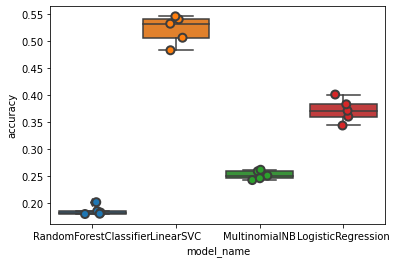

In [17]:
#4 different models

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.522135
LogisticRegression        0.372341
MultinomialNB             0.252594
RandomForestClassifier    0.186438
Name: accuracy, dtype: float64

In [0]:
#using linearSVC
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)


In [20]:
conf_mat.shape

(283, 283)

In [0]:
# fig, ax = plt.subplots(figsize=(255,255))
# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=category_id_df.meddra_term.values, yticklabels=category_id_df.meddra_term.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

In [22]:
#training on features and labels
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "task3_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [0]:
prediction = pickle_model.predict(X_test)


In [25]:
cf_matrix = confusion_matrix(y_test, prediction)
print(cf_matrix)

[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [0]:
import pickle

pkl_filename = "task3_tfidf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(tfidf, file)

In [27]:
# Load from file
with open("task3_tfidf.pkl", 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

test_vector = tfidf_vectorizer.transform(["tweet data is done"])
print(test_vector)

In [28]:
N = 2
for meddra_term, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(meddra_term))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'ADD':
  . Top unigrams:
       . add
       . jacket
  . Top bigrams:
       . feel throat
       . arms amp
# 'MS-like syndrome':
  . Top unigrams:
       . ms
       . like
  . Top bigrams:
       . ms like
       . weight gain
# 'SLE flare':
  . Top unigrams:
       . lupus
       . flare
  . Top bigrams:
       . lupus flare
       . brain shivers
# 'Schizophrenia':
  . Top unigrams:
       . schizophrenia
       . jacket
  . Top bigrams:
       . like chemo
       . brain shivers
# 'TMJ syndrome':
  . Top unigrams:
       . tmj
       . jacket
  . Top bigrams:
       . like shit
       . allergic reaction
# 'abdominal pain':
  . Top unigrams:
       . ab
       . pain
  . Top bigrams:
       . ab pain
       . feel weird
# 'abnormal dreams':
  . Top unigrams:
       . dream
       . dreams
  . Top bigrams:
       . weird dreams
       . fucked dreams
# 'ache':
  . Top unigrams:
       . aches
       . achy
  . Top bigrams:
       . body ache
       . aches pains
# 'achilles ten

In [29]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, labels, target_names=df['meddra_term'].unique()))

                                  precision    recall  f1-score   support

                     vision loss       0.00      0.00      0.00         0
             withdrawal syndrome       0.00      0.00      0.00        13
                        nauseous       0.67      0.67      0.67         3
             inability to orgasm       1.00      1.00      1.00         1
                     weight gain       0.19      0.97      0.31        30
                        headache       0.19      0.97      0.31        30
              condition worsened       1.00      1.00      1.00        11
             appetite suppressed       0.00      0.00      0.00         0
                            pain       0.00      0.00      0.00         1
                   drug toxicity       0.40      0.67      0.50         9
                  feeling unwell       1.00      1.00      1.00         2
                       confusion       0.50      0.25      0.33        12
                       dizziness     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 1829, does not match size of target_names, 477
  .format(len(labels), len(target_names))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
